<a href="https://colab.research.google.com/github/GildasTaliah/RiskBasedOptimz/blob/main/PCAClustOptimzRets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PRINCIPAL COMPONENTS ANALYSIS, CLUSTERING AND OPTIMIZATION OF STOCK RETURNS**


# **Intro**

The idea of Principal Component Analysis (PCA) is to reduce the dimensionality of the dataset with a lrage number of variables while retaining as much variance as possible. Essentially, with PCA we obtain a different representation of the dataset with less dimension that can explain the majority of the entire original data set. In addition the new data set is decorrelated, that is less correlated than before.

Clustering is an unsupervised machnine learning technique (PCA too), wherein we group different parts of our dataset based on their similarity to other observations. Clustering algorithms examine the structure of datasets using some distance metrics inorder to extract commonnality.

In this analysis, we implement PCA to extract factors used in explaining the movements in market returns, we also present other use cases of PCA such as utilizing the data-driven derived risk factors to build trading strategies, and the construction of uncorrelated portfolios using principal components. Additionally, in the context of clustering, we aim to obtain clusters of stocks without labellings, and utilize a clustering technique in the framework of Hierarchical Clustering to build portfolios that outperform out-of-sample.





# **PCA**


PCA by far is the most popular dimensionality reduction technique, first it identifeis the hyperplane that lies closest to the data and then it projects the data unto it.  PCA identifies the axis that accounts for the largest amount of variance in the data. This procedure engineers the translation of a set of correlated data with a high-dimension into a set of uncorrelated components with lower dimension. [More on PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)

How can we obtain principal componets ?

Through a matrix factorization techniqie called **Singular Value decomposition** SVD, that can decompose a dataset or or a given matrix $X$ into the matrix multiplication of three matrices $U \Sigma V^T$, where $V$ is the principal component we are looking for.

$\begin{pmatrix} | & | & | & \cdots & | \\ V_{1} & V_{2} & V_{3} & \cdots & V_{n} \\ | & | & | & \cdots & |  \end{pmatrix}$


Principal component matrix.
The first PC captures the direction of the maximum variance in the data.

In the following, we want to obtain factors that explains the movements in market returns. For this analysis we utilize the DAX 40 and DIJA 30 constituents. We proceed to dowload this stocks as follows.

In [ ]:
# Global imports
import numpy as np
import pandas as pd
import yfinance as yf

In [ ]:
# URL of the Wikipedia page containing the list of DAX 40 companies
url = 'https://en.wikipedia.org/wiki/DAX'

# Read the fourth table on HTML page
dax_table = pd.read_html(url, header=0)[4]

# Extract Ticker column and make list of tickers
dax_tickers = dax_table.Ticker.to_list()

# Display the first few tickers
print(dax_tickers[:5])

['ADS.DE', 'AIR.PA', 'ALV.DE', 'BAS.DE', 'BAYN.DE']


In [ ]:
# URL of the Wikipedia page containing the list of DJIA 30 companies
url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'

# Read the first table on the HTML page
djia_table = pd.read_html(url, header=0)[2]

# Extract Symbol column and make list of tcikers
djia_tickers = djia_table.Symbol.to_list()

# Display the first few tickers
print(djia_tickers[:5])

['MMM', 'AXP', 'AMGN', 'AMZN', 'AAPL']


In [ ]:
Tickers = {'DAX-40': dax_tickers, 'DJIA-30':  djia_tickers}

In [ ]:
# Function to read data from yahoo
def read_data(tickers: list, start: str, end: str, freq: str) -> pd.DataFrame:
   """
   Read data from yahoo finance, takes in list of tickers and returns df with Adj Close prices
   """
   return (yf.download(tickers, start=start, end=end, interval=freq)['Adj Close'])

In [ ]:
# Download data in-sample data
start = '2019-01-01'
end = '2023-09-30'
freq = '1d'
Data = ({key: read_data(ticker, start, end, freq) for key, ticker in
           Tickers.items()})

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  30 of 30 completed


In [ ]:
# Check missing values
{key: data.isnull().values.any() for key , data in Data.items()}

{'DAX-40': True, 'DJIA-30': True}

In [ ]:
miss_data = [Data['DAX-40'][col].isna().sum() for col in Data['DAX-40'].columns]
np.array(miss_data)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         6,   0, 746, 440,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0, 952,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0])

In [ ]:
miss_data = [Data['DJIA-30'][col].isna().sum() for col in Data['DJIA-30'].columns]
np.array(miss_data)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 53,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

The ideal thing to do here is to drop columns with significant amount of missing values, and forward fill, backward fill missing values for those with less such as 6 NAs. We'll just drop the missing values columns.

In [ ]:
# Clean data, drop columns with NA values
Data_c = {key: Data[key].dropna(axis= 1) for key in Data.keys()}

In [ ]:
# Check missing values once more
{key: data.isnull().values.any() for key , data in Data_c.items()}

{'DAX-40': False, 'DJIA-30': False}

In [ ]:
# Compute returns and drop rows with NA values
Returns = {key: data.pct_change().dropna() for key, data in Data_c.items()}

In [ ]:
# Include Market Returns, the average of all constituents
Returns_mrk = {key: returns.assign(MrkRet = returns.mean(axis = 1)) for key, returns in Returns.items()}

In [ ]:
Returns_mrk['DAX-40'].head()

Ticker,ADS.DE,BAS.DE,BAYN.DE,BEI.DE,BMW.DE,BNR.DE,CBK.DE,CON.DE,DB1.DE,DBK.DE,...,MTX.DE,QIA.DE,RWE.DE,SAP.DE,SIE.DE,SY1.DE,VNA.DE,VOW3.DE,ZAL.DE,MrkRet
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03 00:00:00+00:00,0.005384,0.002957,0.000000,0.004990,0.005324,-0.011769,-0.002529,0.021333,0.008763,-0.003008,...,0.008037,0.022368,0.009249,0.013685,0.010760,0.005098,0.023239,0.034641,0.028214,0.009035
2018-01-04 00:00:00+00:00,0.013091,0.021511,0.014202,0.014274,0.007138,0.021130,0.020599,0.010879,0.016753,0.026524,...,0.017276,0.012448,0.000286,0.010843,0.027301,0.010426,-0.001913,0.017499,-0.001992,0.013084
2018-01-05 00:00:00+00:00,0.010573,0.013896,0.037982,0.012441,0.011660,0.008653,-0.017233,0.020663,0.001424,-0.051555,...,0.005878,0.013040,0.010020,0.014197,0.003844,0.022588,0.004790,0.027288,0.000887,0.009708
2018-01-08 00:00:00+00:00,0.004068,0.001687,-0.003142,0.010274,0.013220,-0.000373,-0.001264,0.005905,0.012594,-0.009684,...,0.003247,-0.021331,0.007937,-0.001763,0.007326,-0.015544,0.010966,0.003572,0.003766,0.002362
2018-01-09 00:00:00+00:00,-0.020839,-0.003263,-0.006303,-0.002493,0.005911,0.023134,-0.002689,0.053669,-0.003009,-0.014993,...,0.009709,0.015783,-0.003937,-0.008933,0.004959,-0.005540,-0.001415,0.002224,-0.017656,0.002355


In [ ]:
Returns_mrk['DJIA-30'].head()

Ticker,AAPL,AMZN,BA,CAT,CVX,GS,HD,HON,IBM,INTC,JNJ,JPM,MMM,MRK,NKE,PG,TRV,UNH,V,MrkRet
Date,,,,,,,,,,,,,,,,,,,,
2018-01-03 00:00:00+00:00,-0.000174,0.012775,0.003234,0.001528,0.007289,-0.009309,0.005212,-0.008262,0.027488,-0.033938,0.009553,0.001019,-0.000042,-0.001423,-0.000157,-0.001214,0.003182,0.010490,0.009955,0.001958
2018-01-04 00:00:00+00:00,0.004645,0.004476,-0.003794,0.013733,-0.003113,0.013976,0.007936,0.013513,0.020254,-0.018338,-0.000071,0.014326,0.013071,0.016210,-0.000630,0.007069,0.000000,0.004340,0.003718,0.005859
2018-01-05 00:00:00+00:00,0.011385,0.016163,0.041022,0.015806,-0.001639,-0.005101,0.010446,0.006991,0.004885,0.006977,0.008253,-0.006420,0.007792,-0.001052,0.008512,0.000658,-0.001813,0.019069,0.023949,0.008731
2018-01-08 00:00:00+00:00,-0.003714,0.014425,0.004242,0.025129,0.004926,-0.014520,-0.002390,-0.005400,0.006031,0.000000,0.001270,0.001477,-0.003243,-0.005791,0.008909,0.005261,-0.005372,-0.017357,0.004038,0.000943
2018-01-09 00:00:00+00:00,-0.000115,0.004676,0.026697,0.002409,-0.005369,0.008459,0.005520,0.008207,0.002202,-0.025034,0.015857,0.005069,0.006214,0.002471,-0.007126,-0.007305,0.007760,0.004983,-0.001927,0.002824


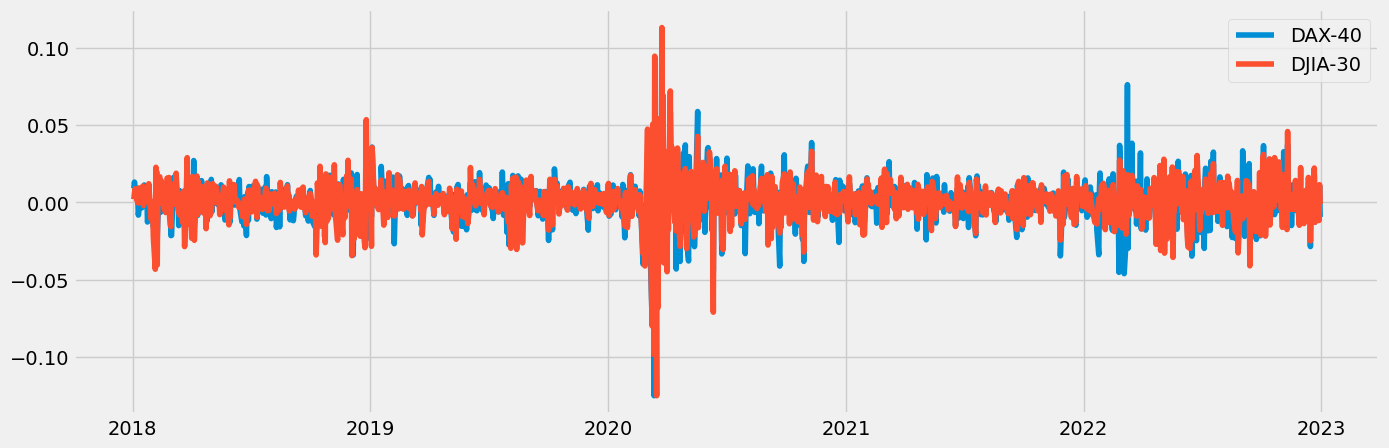

In [ ]:
# Visualize Market Returns

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(figsize=(15, 5))
plt.plot(Returns_mrk['DAX-40'].MrkRet, label = 'DAX-40')
plt.plot(Returns_mrk['DJIA-30'].MrkRet, label = 'DJIA-30')
plt.legend()
plt.show()

We observe that the returns depict characteristics of changing mean and variances across time, making it non-stationary. Non-sataionarity is further confirm  with the existence of visible periods of spikes and volatility clustering, which is quite noticeable during the second quarter of 2020 - the height of the covid era.

In [ ]:
#Returns_mrk['DAX-40'].cov().style.background_gradient(cmap='cividis')

In [ ]:
# Compute covariance
Cov = {key: returns.cov() for key, returns in Returns.items()}

In [ ]:
from sklearn.decomposition import PCA

## Applying PCA on the covariance
# DE: German DAX Stocks
pca_de = PCA()
pca_de.fit(Cov['DAX-40'])

# US: United States DJIA Stocks
pca_us = PCA()
pca_us.fit(Cov['DJIA-30'])

PCA()

In [ ]:
# Compute PC needed to explain 95% variation

def plotPCA(pca: PCA,  var_th: float = 0.95, plot: bool = True) -> None:

  ''' Takes in fitted pca model, obtains minimum number of pc to explain the
  variance of the data, and plots the results.
  '''

  ## Visualizing Variance against number of principal components

  var_threshold = var_th
  var_explained = np.cumsum(pca.explained_variance_ratio_)
  num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1

  if plot:
      print('%d principal components explains %.2f%% of variance' %(num_comp, 100* var_threshold))

      # PCA percent variance explained
      bar_width = 0.9
      n_asset = len(pca.explained_variance_ratio_)
      x_indx = np.arange(n_asset)
      fig, ax = plt.subplots(figsize=(10, 5))


      rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width)
      ax.set_xticks(x_indx + bar_width / 2)
      ax.set_xticklabels(list(range(n_asset)), rotation=45)
      ax.set_title('Percent variance explained')
      ax.set_ylabel('Explained Variance')
      ax.set_xlabel('Principal Components')
      plt.show()

10 principal components explains 95.00% of variance


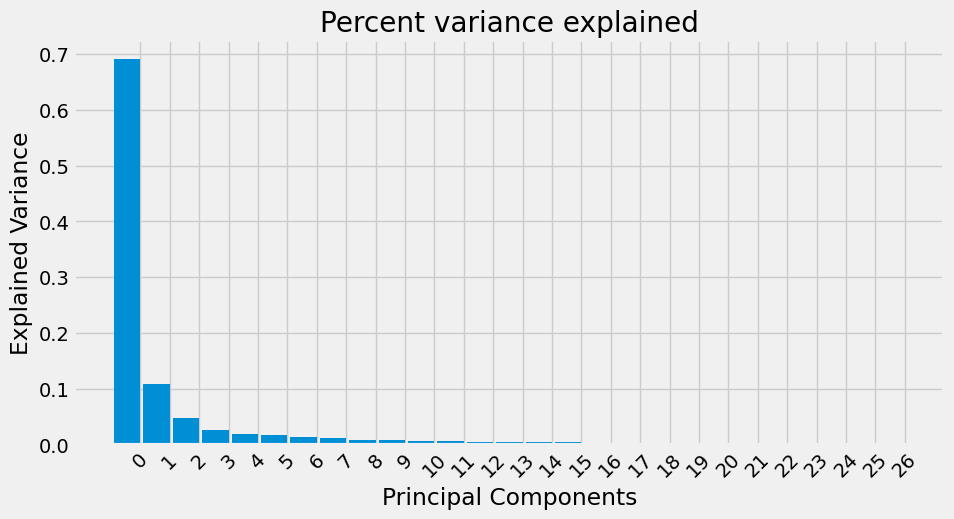

In [ ]:
# Plot for DAX
plotPCA(pca= pca_de)

9 principal components explains 95.00% of variance


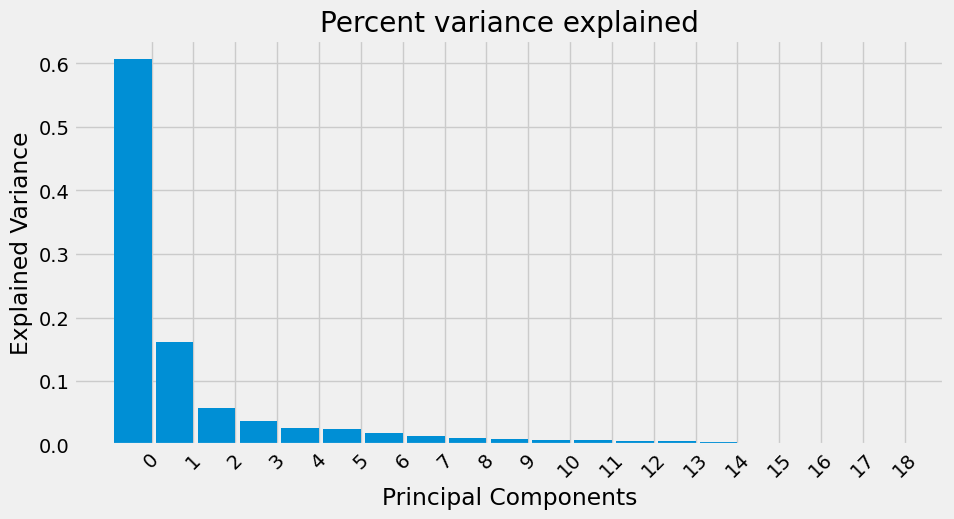

In [ ]:
# Plot for DJIA
plotPCA(pca= pca_us)

As observed, DAX 40 index requires first 11 principal components to explain atleast 95% of the variation in the data, for the case of DJIA 30 we need 10 principal components to do the job.  

$$\quad$$

## **Financial Feature (Factor) Engineering**

Feature engineering in Machine Learning is a key ingredient for successful predictions in predictive analytics, which is no difference with algorithmic trading. Factors are a transformation of market, fundamentals, statistical, structured, unstructured, and alternative data that contain predictive signals. They are designed to capture risk that drive asset's returns. In this analysis our focus will be to obtain statistical features (factors) with PCA.  

There are numerous ways to extract PCA risk factors (risk premia) that can be used  to build a (contemporaneous) regression model to explain asset's returns or be used in a predictive model to predict next day return percentage or market movements.

Let us consider the number of explanatory variables in the universe to be **K**, with PCA we can obtain a smaller number of explanatory variables (factors) **K'**  such that: the level of explanatory power remain as high as possible, moreover the resulting factors are a linear combination of the original explanatory variables, and the resulting factors are orthogonal (uncorrelated).  

Below we present two ways we'll obtain financial features (factors) through PCA:
- 1. First we utilize the covariance matrix of the underlying stock returns, whereby we obtain N principal components from it, and project the returns data unto a hyperplane define by this these components in order to obtain our statistical factors that can now be used as features in our model.
- 2. Secondly we obtain N principal components directly from the underlying returns data and project (transform) the returns data unto a hyperplane defined by the obtained N-principal components and result to N-factors needed for our modelling.   







In [ ]:
#### PCA factors from covariance matrix
####

''' The PCs are the rows thefore we transpose the matrix
'''
## Principal componennts  PC
pcs_covde = pd.DataFrame(pca_de.components_, columns = Returns['DAX-40'].columns).T
pcs_covus = pd.DataFrame(pca_us.components_, columns = Returns['DJIA-30'].columns).T
pcs_covde.columns = ['PC' + str(1+i) for i in range(len(Returns['DAX-40'].columns))]
pcs_covus.columns = ['PC' + str(1 +i) for i in range( len(Returns['DJIA-30'].columns))]
pcs_covde.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
Ticker,,,,,,,,,,,,,,,,,,,,,
ADS.DE,0.135674,0.231239,-0.174046,0.251519,0.042058,0.013892,0.155645,0.815386,0.136504,-0.241189,...,0.059717,-0.069042,0.044080,0.064990,-0.000540,-0.104997,0.021044,-0.033288,0.009334,-0.060053
BAS.DE,0.226907,-0.032835,-0.055500,-0.056899,-0.074611,-0.051142,0.060851,0.054866,0.039415,0.125066,...,-0.057608,-0.042616,0.071565,-0.109531,0.215708,0.146235,-0.081228,0.779224,-0.280363,0.083694
BAYN.DE,0.141734,-0.075134,0.015020,0.020593,-0.085766,-0.277918,0.449366,-0.126517,0.677658,0.265403,...,0.042357,-0.054769,0.007986,0.082164,-0.042539,-0.051872,-0.051995,-0.092058,0.022042,0.045060
BEI.DE,-0.001693,0.004532,-0.053169,0.021512,-0.084243,0.023574,0.042786,0.036658,0.007282,-0.106828,...,-0.120090,0.196070,-0.076953,0.353982,-0.267854,0.199576,-0.631219,-0.086183,-0.173063,0.383593
BMW.DE,0.243248,-0.019354,-0.152955,-0.225003,-0.123298,0.002424,-0.092762,-0.004612,0.033378,-0.018957,...,-0.005151,-0.049745,0.012854,0.079520,0.156745,-0.062343,-0.029494,0.146747,0.769122,0.357370


In [ ]:
# Create/Obtain column names and index
cols_de = ['Fac' + str(1+i) for i in range(len(Returns['DAX-40'].columns))]
cols_us =['Fac' + str(1 +i) for i in range( len(Returns['DJIA-30'].columns))]
index_de = Returns['DAX-40'].index
index_us = Returns['DJIA-30'].index

In [ ]:
## Factors (Financial Features)
fact_pca_covde = Returns['DAX-40'] @ pcs_covde
fact_pca_covus = Returns['DJIA-30'] @ pcs_covus

fact_pca_covde.columns = cols_de
fact_pca_covus.columns = cols_us

fact_pca_covus.head()

,Fac1,Fac2,Fac3,Fac4,Fac5,Fac6,Fac7,Fac8,Fac9,Fac10,Fac11,Fac12,Fac13,Fac14,Fac15,Fac16,Fac17,Fac18,Fac19
Date,,,,,,,,,,,,,,,,,,,
2018-01-03 00:00:00+00:00,0.001981,-0.005808,0.012645,-0.021700,0.015857,-0.003856,0.006105,0.014235,-0.013164,0.018733,0.020713,0.010461,-0.010589,-0.004690,-0.002507,-0.007488,0.009289,0.003210,0.010164
2018-01-04 00:00:00+00:00,0.013898,-0.007355,-0.011215,-0.019662,-0.000903,0.000514,-0.012249,0.020070,-0.007155,0.003781,0.008590,0.002869,-0.007282,-0.010353,0.012174,0.007268,-0.006601,0.003964,0.016793
2018-01-05 00:00:00+00:00,0.043344,0.018924,0.020479,0.002974,-0.001839,-0.000730,0.012306,0.021907,0.004685,0.004638,0.000428,0.016128,0.007647,-0.004092,-0.003431,-0.007022,0.002978,-0.001682,0.003895
2018-01-08 00:00:00+00:00,0.006723,0.007030,0.000394,-0.011568,-0.016243,-0.018752,0.013278,-0.009317,-0.002378,0.001563,0.002600,0.008404,-0.003569,-0.011319,-0.014316,-0.001282,0.004953,0.009201,0.005448
2018-01-09 00:00:00+00:00,0.019395,-0.013372,0.022382,-0.013038,0.005585,-0.005222,-0.013795,0.013585,0.002480,0.005271,-0.002442,0.001116,-0.001643,0.002457,0.008790,-0.003492,0.012376,-0.006924,0.009234


In [ ]:
#### PCA factors from returns
####

## Instantiate model
pca = PCA()
# Performs PCA on smaller number of predictors
pca.fit(Returns['DAX-40'] )
# Rotation, so PCs are the columns
P=pd.DataFrame(pca.components_,columns= Returns['DAX-40'].columns ).T
# Tidying up columns names
P.columns = ['P' + str(col + 1) for col in P.columns]
# Now project the returns unto the hyperplane defined by the pca

fact_pret_de = pd.DataFrame( np.matmul( Returns['DAX-40'].values ,P))
fact_pret_de.index = Returns['DAX-40'].index
fact_pret_de

## Shorter approach: fit pca model and transform (project)
## Factors (Financial Features)
# DAX DE
fact_pca_retde = pd.DataFrame( PCA().fit_transform(Returns['DAX-40']), columns = cols_de, index= index_de )

# DJIA US
fact_pca_retus = pd.DataFrame( PCA().fit_transform(Returns['DJIA-30']), columns = cols_us, index= index_us )
fact_pca_retde.head()

,Fac1,Fac2,Fac3,Fac4,Fac5,Fac6,Fac7,Fac8,Fac9,Fac10,...,Fac18,Fac19,Fac20,Fac21,Fac22,Fac23,Fac24,Fac25,Fac26,Fac27
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03 00:00:00+00:00,0.044798,0.033813,0.007084,-0.020371,-0.007415,0.011040,-0.020222,-0.011365,0.005430,0.002954,...,-0.000199,-0.015062,0.005518,-0.007672,-0.012721,-0.002972,0.009927,0.000316,0.003148,-0.004540
2018-01-04 00:00:00+00:00,0.068348,-0.010157,-0.012774,0.009794,-0.002256,0.010222,0.020980,0.004337,0.002963,-0.006968,...,0.002058,0.005953,-0.000855,0.002610,-0.010843,0.005199,0.008590,-0.004128,-0.001573,-0.005845
2018-01-05 00:00:00+00:00,0.035381,0.041247,-0.044141,-0.028720,-0.018668,-0.006559,0.030339,-0.009318,0.008197,0.016695,...,-0.003910,-0.005724,-0.004111,-0.004062,-0.003367,0.000281,-0.009779,0.004627,0.009811,-0.004840
2018-01-08 00:00:00+00:00,0.015063,0.001185,-0.004502,-0.019157,0.003343,-0.015478,-0.007474,0.005552,-0.018049,-0.004567,...,0.013792,0.000161,0.001638,-0.010904,0.004554,-0.001999,0.014091,0.000343,-0.002898,0.008729
2018-01-09 00:00:00+00:00,0.014533,-0.014333,-0.013015,-0.033610,-0.010281,0.016508,0.001303,-0.025875,0.018617,-0.007995,...,0.022500,0.013070,-0.016958,0.006693,-0.006722,-0.012236,0.008881,0.017745,-0.004378,0.001411


Having done the transformation it is now possible to select a subsample of the transformed data. From our N-possible factors we select the first five for this analysis.

It is worth knowing that it is also possble to select a number of factors such that the number of PCs explains a desired proportion of the variation on the underlying data set, maybe 95% for example.

In [ ]:
import statsmodels.api as sm

## DAX - 40
# Explanatory and depenent variable: PCA covariance
X = fact_pca_covde.iloc[:, :5]
y = Returns['DAX-40'].mean(axis = 1).rename('MrkRet')  #Returns_mrk['DAX-40'].MrkRet

# Add a constant (intercept) and fit the OLS model
ols_model = sm.OLS(y, sm.add_constant(X)).fit()

# Get summary
summary = ols_model.summary()

# Print summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:                 MrkRet   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     7835.
Date:                Fri, 11 Oct 2024   Prob (F-statistic):               0.00
Time:                        05:51:15   Log-Likelihood:                 5889.4
No. Observations:                1268   AIC:                        -1.177e+04
Df Residuals:                    1262   BIC:                        -1.174e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.165e-05   6.56e-05      0.788      0.4

In [ ]:
## DAX - 40
# Explanatory and depenent variable: PCA returns
X = fact_pca_retde.iloc[:, :5]
y = Returns['DAX-40'].mean(axis = 1).rename('MrkRet')

# Add a constant (intercept) and fit the OLS model
ols_model = sm.OLS(y, sm.add_constant(X)).fit()

# Get summary
summary = ols_model.summary()

# Print summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:                 MrkRet   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.141e+05
Date:                Fri, 11 Oct 2024   Prob (F-statistic):               0.00
Time:                        05:51:15   Log-Likelihood:                 8210.0
No. Observations:                1268   AIC:                        -1.641e+04
Df Residuals:                    1262   BIC:                        -1.638e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   1.05e-05     23.802      0.0

In [ ]:
## DJIA - 30
# Explanatory and depenent variable: PCA Covariance
X = fact_pca_covus.iloc[:, :5]
y = Returns['DJIA-30'].mean(axis = 1).rename('MrkRet')  #Returns_mrk['DJIA-30'].MrkRet

# Add a constant (intercept) and fit the OLS model
ols_model = sm.OLS(y, sm.add_constant(X)).fit()

# Get summary
summary = ols_model.summary()

# Print summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:                 MrkRet   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     8820.
Date:                Fri, 11 Oct 2024   Prob (F-statistic):               0.00
Time:                        05:51:15   Log-Likelihood:                 5840.5
No. Observations:                1258   AIC:                        -1.167e+04
Df Residuals:                    1252   BIC:                        -1.164e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.192e-05    6.6e-05      1.241      0.2

In [ ]:
## DJIA - 30
# Explanatory and depenent variable: PCA returns
X = fact_pca_retus.iloc[:, :5]
y = Returns['DJIA-30'].mean(axis = 1).rename('MrkRet')

# Add a constant (intercept) and fit the OLS model
ols_model = sm.OLS(y, sm.add_constant(X)).fit()

# Get summary
summary = ols_model.summary()

# Print summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:                 MrkRet   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.458e+05
Date:                Fri, 11 Oct 2024   Prob (F-statistic):               0.00
Time:                        05:51:15   Log-Likelihood:                 8290.7
No. Observations:                1258   AIC:                        -1.657e+04
Df Residuals:                    1252   BIC:                        -1.654e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005   9.39e-06     56.714      0.0

In [ ]:
Returns['DAX-40'].head()

Ticker,ADS.DE,BAS.DE,BAYN.DE,BEI.DE,BMW.DE,BNR.DE,CBK.DE,CON.DE,DB1.DE,DBK.DE,...,MRK.DE,MTX.DE,QIA.DE,RWE.DE,SAP.DE,SIE.DE,SY1.DE,VNA.DE,VOW3.DE,ZAL.DE
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03 00:00:00+00:00,0.005384,0.002957,0.000000,0.004990,0.005324,-0.011769,-0.002529,0.021333,0.008763,-0.003008,...,0.009780,0.008037,0.022368,0.009249,0.013685,0.010760,0.005098,0.023239,0.034641,0.028214
2018-01-04 00:00:00+00:00,0.013091,0.021511,0.014202,0.014274,0.007138,0.021130,0.020599,0.010879,0.016753,0.026524,...,-0.001761,0.017276,0.012448,0.000286,0.010843,0.027301,0.010426,-0.001913,0.017499,-0.001992
2018-01-05 00:00:00+00:00,0.010573,0.013896,0.037982,0.012441,0.011660,0.008653,-0.017233,0.020663,0.001424,-0.051555,...,0.031092,0.005878,0.013040,0.010020,0.014197,0.003844,0.022588,0.004790,0.027288,0.000887
2018-01-08 00:00:00+00:00,0.004068,0.001687,-0.003142,0.010274,0.013220,-0.000373,-0.001264,0.005905,0.012594,-0.009684,...,-0.004919,0.003247,-0.021331,0.007937,-0.001763,0.007326,-0.015544,0.010966,0.003572,0.003766
2018-01-09 00:00:00+00:00,-0.020839,-0.003263,-0.006303,-0.002493,0.005911,0.023134,-0.002689,0.053669,-0.003009,-0.014993,...,0.006877,0.009709,0.015783,-0.003937,-0.008933,0.004959,-0.005540,-0.001415,0.002224,-0.017656


## PCA BAsed Portfolio Allocation

Portfolio weights can be obtained proportionately or inversely proportional based on the principal components loadings. With proportional we are maximizing the exposure to dominant factors driving the returns, inversely proportional we would imply we create a portfolio less sensitive to to dominant risk factors driving the returns. Either approach in my opinion is remotely associated with the concept of factor investing but adhere to different risk appetite.


-- Examine the PCA tha was good in-sample, try if it beats other pcas out-sample.

In [ ]:
pcs_covde.PC1

,PC1
Ticker,
ADS.DE,0.135674
BAS.DE,0.226907
BAYN.DE,0.141734
BEI.DE,-0.001693
BMW.DE,0.243248
BNR.DE,0.118357
CBK.DE,0.420645
CON.DE,0.321324
DB1.DE,0.032325


In [ ]:
pca_de.components_[:, 0] #/ pca_de.components_[:,0].sum()

array([ 1.35674276e-01,  2.31239384e-01, -1.74045628e-01,  2.51518561e-01,
        4.20579473e-02,  1.38920950e-02,  1.55645216e-01,  8.15385844e-01,
        1.36504421e-01, -2.41189345e-01,  5.36001501e-02, -1.13955676e-02,
       -1.40598547e-01, -7.10536417e-02, -2.50397201e-02, -5.52395397e-02,
       -6.67355863e-02,  5.97169244e-02, -6.90419094e-02,  4.40796819e-02,
        6.49895257e-02, -5.40480939e-04, -1.04997498e-01,  2.10439686e-02,
       -3.32879205e-02,  9.33426135e-03, -6.00534965e-02])

In [ ]:
f = pd.DataFrame( pca_de.components_)
f

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.135674,0.226907,0.141734,-0.001693,0.243248,0.118357,0.420645,0.321324,0.032325,0.359646,...,0.020865,0.236440,-0.062517,0.024403,0.075135,0.187542,-0.021346,-0.007662,0.290273,0.102341
1,0.231239,-0.032835,-0.075134,0.004532,-0.019354,0.069305,-0.273521,0.063526,0.058723,-0.178673,...,0.104679,-0.070003,0.112466,0.019291,0.138603,0.058909,0.119849,0.153978,0.041823,0.801422
2,-0.174046,-0.055500,0.015020,-0.053169,-0.152955,-0.034890,0.523561,-0.170790,-0.037803,0.442708,...,0.001429,-0.347750,0.087214,-0.069050,-0.106278,-0.084421,-0.031097,-0.066401,-0.217484,0.407354
3,0.251519,-0.056899,0.020593,0.021512,-0.225003,-0.015302,0.142216,-0.291404,0.076121,0.080420,...,0.042578,0.749948,-0.089345,0.138200,0.034613,-0.035076,-0.010182,0.101357,-0.241746,0.086348
4,0.042058,-0.074611,-0.085766,-0.084243,-0.123298,0.113800,0.119644,-0.128190,0.053929,0.102691,...,0.199739,-0.037737,0.430455,-0.143714,0.176157,0.097358,0.214107,-0.110014,-0.067760,-0.326694
5,0.013892,-0.051142,-0.277918,0.023574,0.002424,-0.049208,0.061790,-0.082370,0.100884,0.120190,...,0.094885,-0.220192,-0.203230,0.623987,0.050276,-0.003691,0.021226,0.320210,0.055271,-0.132846
6,0.155645,0.060851,0.449366,0.042786,-0.092762,-0.000308,-0.083273,-0.271275,0.167478,0.076888,...,0.055773,-0.323237,-0.315421,0.136165,0.143260,0.095708,0.004752,-0.052327,-0.147924,-0.079408
7,0.815386,0.054866,-0.126517,0.036658,-0.004612,-0.049940,0.040630,0.127412,-0.121471,0.122688,...,-0.058840,-0.239895,-0.051254,-0.228790,-0.039880,0.061119,0.009013,0.181112,-0.069813,-0.165988
8,0.136504,0.039415,0.677658,0.007282,0.033378,-0.012856,-0.130848,0.007002,-0.036233,0.015957,...,0.045541,-0.006390,0.120842,0.150735,-0.179022,-0.037683,0.007414,-0.231172,0.118632,0.034164
9,-0.241189,0.125066,0.265403,-0.106828,-0.018957,0.170242,-0.067131,-0.198437,0.015211,0.051516,...,0.054716,0.004181,-0.211676,-0.351102,0.138507,0.157798,0.161363,0.644176,0.016105,-0.039037


In [ ]:
# Obtain weights for each eigen portfolio
# Verify weights sum up to one
w_pcs_de = pcs_covde.div(pcs_covde.sum(axis = 0), axis = 1)
print('DAX. Sum of weight under each normalized PC: ', np.array(w_pcs_de.sum()), '\n')
w_pcs_us = pcs_covus.div(pcs_covus.sum(axis = 0), axis = 1)
print( 'DJIA. Sum of weight under each normalized PC: ', np.array(w_pcs_us.sum()) )

DAX. Sum of weight under each normalized PC:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.] 

DJIA. Sum of weight under each normalized PC:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<Axes: xlabel='Ticker'>

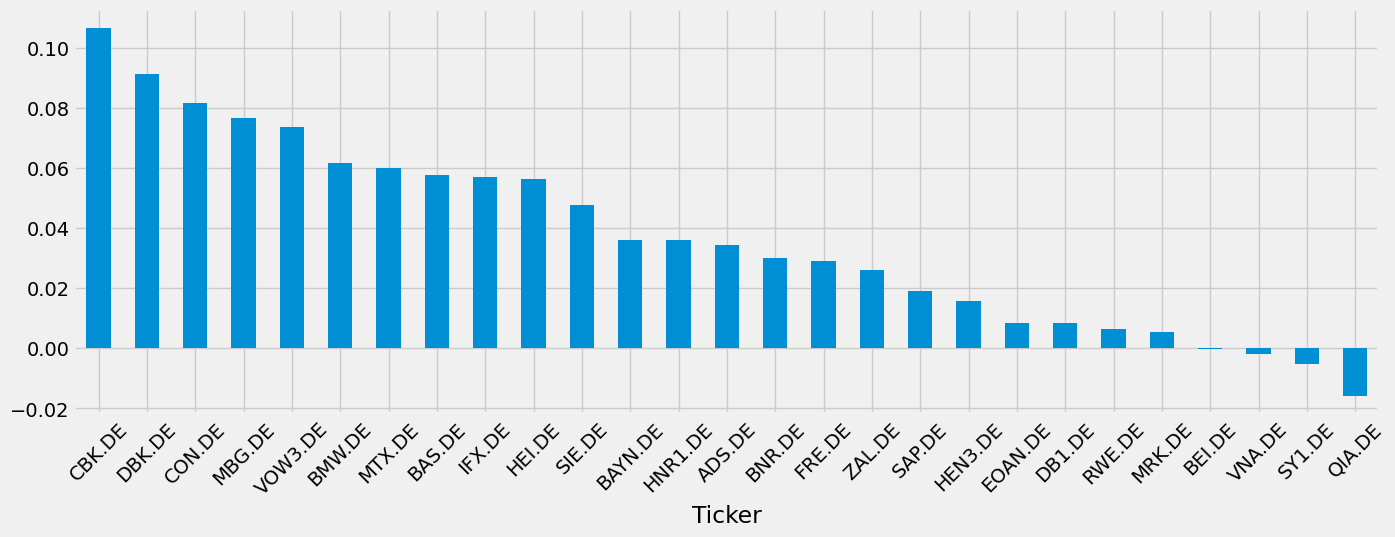

In [ ]:
w_pcs_de.PC1.sort_values(ascending = False).plot.bar(label = 'PC1', rot = 45, figsize = (15, 5))

<Axes: xlabel='Ticker'>

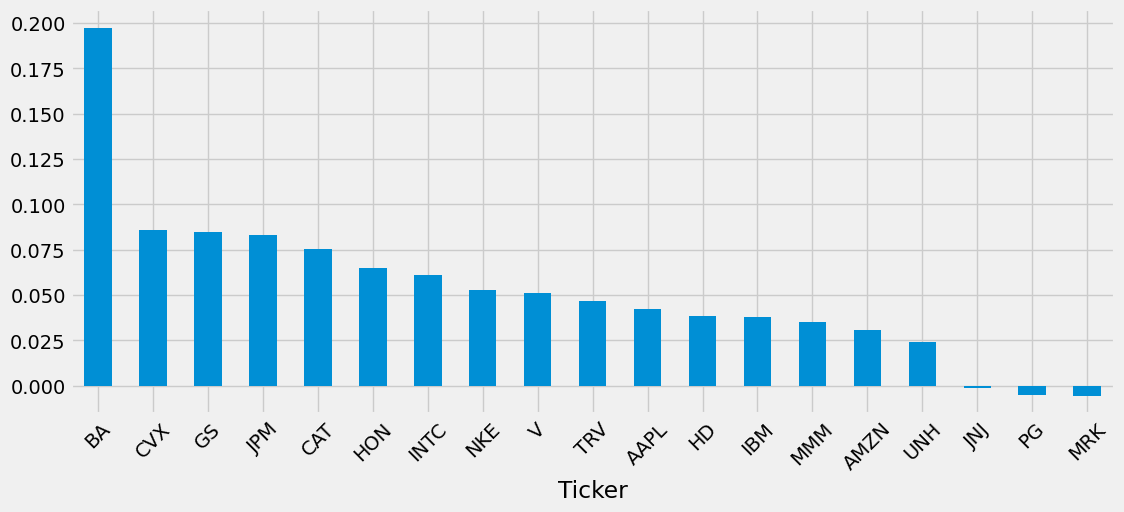

In [ ]:
w_pcs_us.PC1.sort_values(ascending = False).plot.bar(label = 'PC1', rot = 45, figsize = (12, 5))

In [ ]:
## In-sample results for eigen portfolios
eigen_port_de =  (Returns['DAX-40'] @ w_pcs_de)
eigen_port_us = (Returns['DJIA-30'] @ w_pcs_us)

In [ ]:
# In-sample 'Low Volatility Eigen Portoflios': lvep
lvep_de = eigen_port_de.describe().iloc[1:,:].T.nsmallest(5, 'std').T.mul(100).round(2)
lvep_de

,PC27,PC26,PC1,PC19,PC13
mean,0.02,-0.02,0.02,0.08,0.14
std,0.91,1.56,1.74,1.76,2.08
min,-7.50,-8.75,-15.35,-12.55,-10.35
25%,-0.47,-0.91,-0.75,-0.89,-1.01
50%,0.02,-0.06,0.03,0.08,0.12
75%,0.54,0.89,0.81,1.05,1.31
max,5.13,9.36,13.31,13.86,12.26


In [ ]:
lvep_us = eigen_port_us.describe().iloc[1:,:].T.nsmallest(5, 'std').T.mul(100).round(2)
lvep_us

,PC19,PC1,PC3,PC8,PC6
mean,0.05,0.05,0.05,0.08,0.10
std,1.09,1.73,2.01,2.08,2.28
min,-7.05,-15.30,-11.35,-18.04,-21.87
25%,-0.46,-0.68,-0.98,-1.13,-1.08
50%,0.09,0.08,0.04,0.08,0.07
75%,0.62,0.84,1.06,1.26,1.30
max,7.40,14.27,14.80,12.56,15.28


In [ ]:
# Eigen portfolios loadings with the lowest in-sample variance (Top 5)
nameslvep_de, nameslvep_us = list(lvep_de.columns), list(lvep_us.columns)
nameslvep_de, nameslvep_us

(['PC27', 'PC26', 'PC1', 'PC19', 'PC13'], ['PC19', 'PC1', 'PC3', 'PC8', 'PC6'])

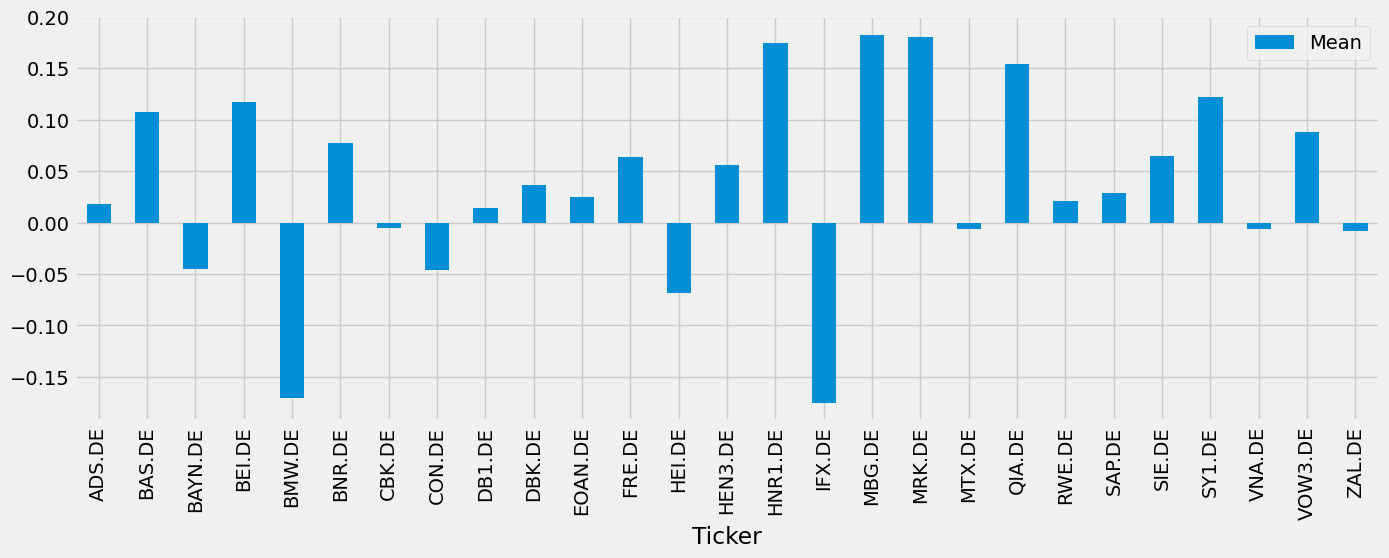

0.9999999999999999

In [ ]:
#w_pcs_de[nameslvep_de].plot.bar( figsize = (15, 5), rot = 45)
w_pcs_de[nameslvep_de].mean(axis = 1).plot.bar(label = 'Mean', figsize = (15, 5))
plt.legend()
plt.show()

w_pcs_de[nameslvep_de].mean(axis =1).sum()

In [ ]:
#!pip install riskfolio-lib

In [ ]:
eigen_port_de.cumsum().apply(np.exp) #.plot(label = 'DAX-40')
#eigen_port_us.cumsum().apply(np.exp).plot(label = 'DJIA-30')
#plt.legend()
#plt.figure(figsize=(25, 15))
#plt.show()


# Place the legend outside the plot
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Set the figure size
#plt.figure(figsize=(25, 15))

# Show the plot
#plt.show()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03 00:00:00+00:00,1.008668,1.031537,1.024594,0.986036,1.042040,1.021396,0.979177,1.029399,1.029107,1.023530,...,0.654660,0.995535,1.295735,0.989680,1.060371,1.139350,1.008434,0.996240,1.013271,1.004368
2018-01-04 00:00:00+00:00,1.025422,1.030694,1.035123,0.999887,1.080938,1.006361,1.002025,1.029272,1.005027,1.029076,...,0.793488,1.009302,1.270841,0.965608,1.087399,1.343492,0.961082,1.020614,1.034757,1.014334
2018-01-05 00:00:00+00:00,1.029646,1.050917,1.123505,0.973407,1.073707,0.989898,1.031366,1.084117,1.141306,1.026260,...,0.686031,1.019151,1.054185,0.974777,1.098107,1.216258,1.055945,1.001107,1.062882,1.028782
2018-01-08 00:00:00+00:00,1.033785,1.056458,1.153020,0.969906,1.031402,1.007815,1.040046,1.089555,1.087327,1.039426,...,0.694044,1.012757,1.130106,1.017660,1.126337,1.434582,1.045560,1.005533,1.044690,1.027470
2018-01-09 00:00:00+00:00,1.038793,1.050167,1.198968,0.932218,1.064992,0.982464,1.002375,1.148066,1.059184,1.013676,...,1.048050,1.041937,0.519764,1.009883,1.212348,1.509223,1.356712,1.025107,1.043292,1.030436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 00:00:00+00:00,1.226741,1.532262,1.677922,4.092827,12.992383,6.822998,0.738736,32.152717,13.216428,0.345845,...,5563.198420,2.837622,114998.429005,1.244542,0.591436,0.825808,0.096566,2.939108,0.755214,1.266212
2022-12-27 00:00:00+00:00,1.231257,1.538194,1.690796,4.127179,12.650129,6.795967,0.728100,31.897352,13.274985,0.350977,...,5125.490544,2.874857,128221.584541,1.235286,0.580804,0.799485,0.086279,2.959303,0.763155,1.269677
2022-12-28 00:00:00+00:00,1.223337,1.536995,1.675294,4.130409,12.555558,6.760442,0.723799,31.797032,13.683834,0.363861,...,6100.632945,2.861845,90053.009802,1.240494,0.572500,0.791156,0.085892,2.915352,0.762287,1.269798


In [ ]:
#  Function to compute out-sample portfolio performance metrics ü

def MaxDrawdown(returns: pd.DataFrame)-> float:
  """ Takes in portfolio return data, and computes maximum drawdown from peak to trough
  """
  cum_ret = (1 + returns).cumprod()
  cum_ret_max = cum_ret.cummax()
  max_drawdown = (cum_ret - cum_ret_max) / cum_ret_max

  return max_drawdown.min()

def perf_metrics(port_ret: pd.DataFrame, sig: float=0.05) -> list[float]:

  """ Takes in portfolio return df, and computes metrics.
  sig: the significance level for VaR and CVaR, defaul 5%
  """

  # Compute portfolio performance metrics
  ann_ret = np.nanmean(port_ret) * 252 * 100                    # annualized average returns
  vol = np.nanstd(port_ret) * np.sqrt(252) * 100                # annualized volatility
  SR = ann_ret / vol                                            # Sharpe ratio
  geo_mean = (np.exp(np.log(1 + port_ret)).mean()) - 1          # geometric returns
  ann_gm = ((1 + geo_mean) ** len(port_ret) - 1 ) * 100         # annualized geometric returns
  #cumret = (np.exp(port_ret.sum()) - 1) * 100                  # cumulative returns same as Ann. Geo Returns
  d_vol = np.nanstd(port_ret[port_ret<0]) * np.sqrt(252) * 100  # annualized downside deviation
  MDD = MaxDrawdown(port_ret) * 100                             # maximum drawdown (daily)
  VaR = port_ret.quantile(sig)                                  # daily VaR
  CVaR = (port_ret[port_ret<=VaR].mean())                       # daily CVaR

  # Metrics
  mets = [ann_ret, vol, SR, ann_gm, d_vol, MDD, VaR * 100, CVaR * 100]

  return mets

In [ ]:
# @title Out-Sample Result
# Use color map summer on rows: green to yellow
#out_results =  {key: df.apply(perf_metrics).T for key, df in .items()}
out_results = eigen_port_de.apply(perf_metrics)
#out_results = pd.concat(out_results)
out_results.index = ['Annz. Ret', 'Annz. Vol', 'Sharpe Ratio', 'Annz. G.Ret',   'Down_Vol', 'MaxDrawD', 'VaR_5%', 'CVaR_5%']
out_results.T.nsmallest(15, 'Annz. Vol').T.style.format(precision=2)\
   .background_gradient(cmap = 'summer', axis=1)
#out_results

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PC27,PC26,PC1,PC19,PC13,PC2,PC12,PC7,PC6,PC3,PC11,PC4,PC25,PC21,PC22
Annz. Ret,4.72,-5.34,4.01,20.79,36.04,8.77,-6.07,-6.13,38.32,10.38,0.78,27.86,21.82,4.01,-11.64
Annz. Vol,14.49,24.80,27.64,27.87,33.04,35.19,37.37,37.63,43.79,54.50,56.20,57.01,59.75,64.79,67.82
Sharpe Ratio,0.33,-0.22,0.15,0.75,1.09,0.25,-0.16,-0.16,0.88,0.19,0.01,0.49,0.37,0.06,-0.17
Annz. G.Ret,26.79,-23.56,22.38,184.56,512.50,55.46,-26.31,-26.55,586.82,68.57,4.00,305.94,199.65,22.36,-44.34
Down_Vol,10.73,15.85,21.61,18.79,21.21,24.30,25.93,26.22,29.62,37.71,38.31,38.15,38.62,42.00,45.75
MaxDrawD,-21.43,-45.92,-54.73,-30.64,-33.05,-72.50,-64.91,-59.20,-36.60,-77.08,-72.31,-79.26,-58.83,-86.29,-94.36
VaR_5%,-1.42,-2.40,-2.51,-2.69,-3.10,-3.82,-3.95,-3.73,-3.96,-5.13,-5.19,-5.31,-5.95,-6.61,-6.90
CVaR_5%,-2.17,-3.35,-4.16,-3.84,-4.39,-5.09,-5.50,-5.47,-6.05,-7.83,-7.74,-7.82,-8.24,-8.93,-9.74


In [ ]:
out_results.T.nsmallest(15, 'Annz. Vol').T.style.format(precision=2)\
   .background_gradient(cmap = 'summer', axis=1)

,PC27,PC26,PC1,PC19,PC13,PC2,PC12,PC7,PC6,PC3,PC11,PC4,PC25,PC21,PC22
Annz. Ret,4.72,-5.34,4.01,20.79,36.04,8.77,-6.07,-6.13,38.32,10.38,0.78,27.86,21.82,4.01,-11.64
Annz. Vol,14.49,24.80,27.64,27.87,33.04,35.19,37.37,37.63,43.79,54.50,56.20,57.01,59.75,64.79,67.82
Sharpe Ratio,0.33,-0.22,0.15,0.75,1.09,0.25,-0.16,-0.16,0.88,0.19,0.01,0.49,0.37,0.06,-0.17
Annz. G.Ret,26.79,-23.56,22.38,184.56,512.50,55.46,-26.31,-26.55,586.82,68.57,4.00,305.94,199.65,22.36,-44.34
Down_Vol,10.73,15.85,21.61,18.79,21.21,24.30,25.93,26.22,29.62,37.71,38.31,38.15,38.62,42.00,45.75
MaxDrawD,-21.43,-45.92,-54.73,-30.64,-33.05,-72.50,-64.91,-59.20,-36.60,-77.08,-72.31,-79.26,-58.83,-86.29,-94.36
VaR_5%,-1.42,-2.40,-2.51,-2.69,-3.10,-3.82,-3.95,-3.73,-3.96,-5.13,-5.19,-5.31,-5.95,-6.61,-6.90
CVaR_5%,-2.17,-3.35,-4.16,-3.84,-4.39,-5.09,-5.50,-5.47,-6.05,-7.83,-7.74,-7.82,-8.24,-8.93,-9.74


## PCA Based Trading Strategy

Algorithmic Trading stratgies are driven by signals that indicate when to buy and sell to generate superior returns relative to benchmark such as index. The portion of the asset's return that is not explianed by the exposure to the benchmark is called **Alpha**, and hence the signal that aims to produce such as uncorrelated returns are called **Alpha Factors**.

# **ML Asset Allocation**

Machine Learning (ML) asset allocation refers to the use of ML algorithms and techniques to determine the optimal assets weights in an investment portfolio often with the goal to mitigate risk while aiming for maximum returns on investment. There are wide range activities that can be carried out using ML algorithms techniques, such as utilizing supervise learning models to predict stock price percentage or market movements, utilizing clustering to classify stocks into different regimes based on historical data, or clustering a collection stocks into groups with similar characteristics, applying genetic algorithm to find optimal portfolio wweights that balances risk ad return, or applying hierarchical clustering for weight allocation as we'll see below.

# **Clustering**

This type of ML algorithm is trained on a set of input data (features) along with a desired output data (labels), such that the model is capable of disecting and uncovering hidden patterns between the input and out data. Unsupervised Learning: This type of ML algorthing tries to extract structure from a given dataset with no labels given. Reinforcement learning: Is a ML algorithm that allows for the specification of one or more intelligent agents whose decisions evolve as the model is trained according to a specified cost function.

# **K-Means Clustering for Portfolio Optimization**

K-Means clustering is a popular unsupervised ML algorithm that can be applied to portfolio optimzation.

For example by grouping similar assets together based on characteristics (e.g., historical data returns,  average (expected) returns, volatility, fundamentals such as Price to Earnings ratio,...)



In [ ]:
#!pip install riskfolio-lib

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# from sklearn.cluster import KMeans

from sklearn.cluster import KMeans
n = 4
kmeans = KMeans(n_clusters=n, random_state=75).fit(Returns['DAX-40'].T)
labels = kmeans.labels_ # kmeans.fit_predict(Returns['DAX-40']) # kmeans.labels_
centers = kmeans.cluster_centers_
#centers
labels

array([1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 2, 2,
       1, 2, 2, 1, 3], dtype=int32)

In [ ]:
pd.DataFrame({'labels': labels, 'column_name': Returns['DAX-40'].columns}).sort_values(by = 'labels')
pd.DataFrame({'labels': labels, 'column_name': Returns['DAX-40'].columns}).nlargest(15, 'labels')

NameError: name 'pd' is not defined

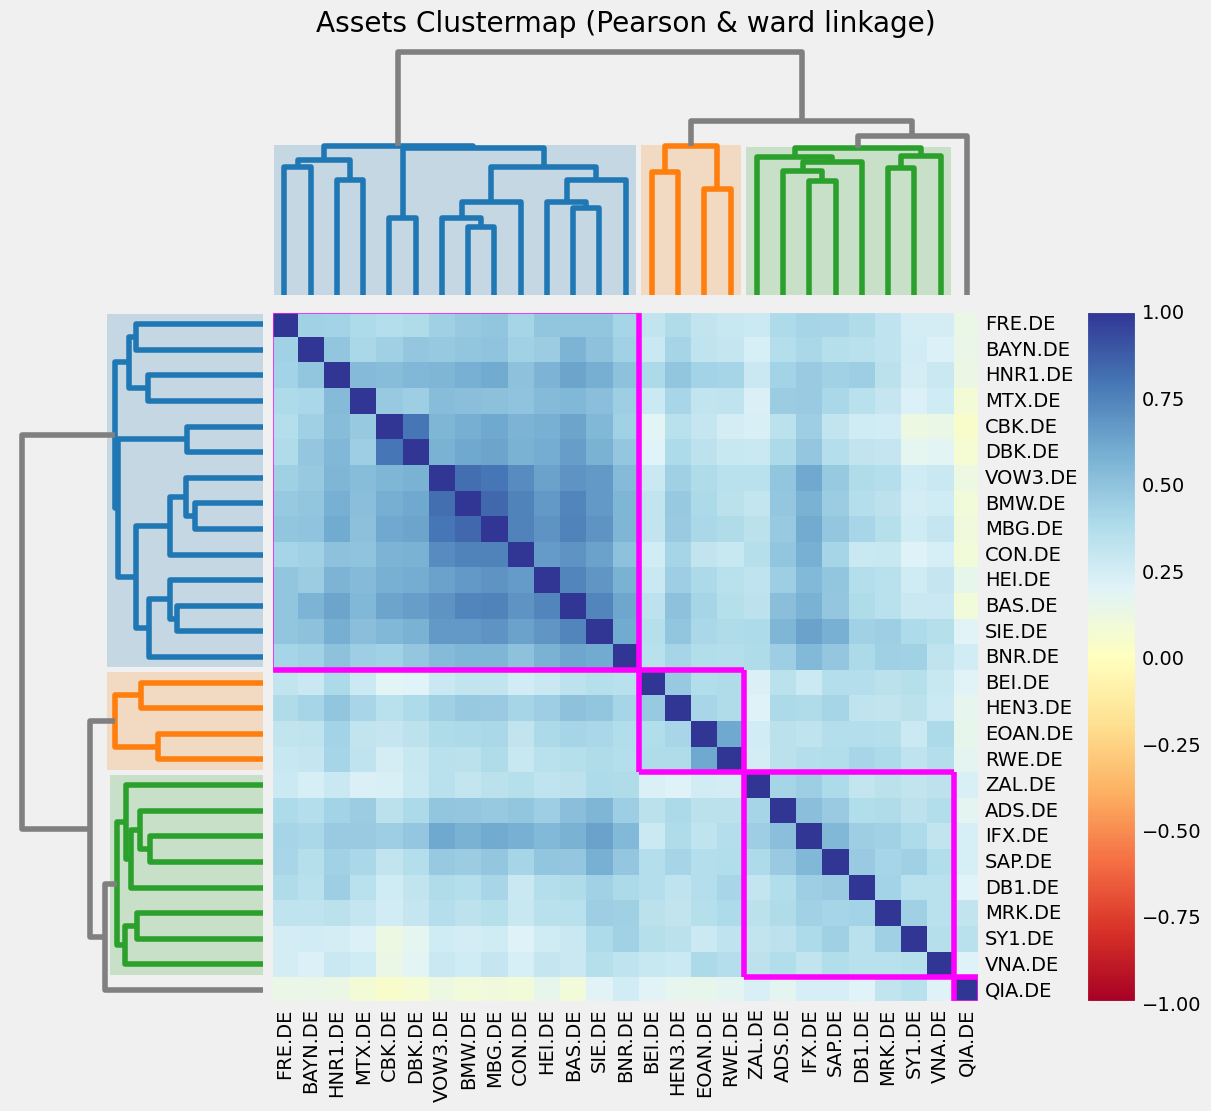

In [ ]:
# Plotting Assets Clusters
import riskfolio as rp

plt.figure(figsize= (10,10))
ax = rp.plot_clusters(returns= Returns['DAX-40'] ,
                      codependence='pearson',
                      linkage='ward',
                      k=4, #None,
                      #max_k=10,
                      leaf_order=True,
                      dendrogram=True,
                      #linecolor='tab:purple',
                      ax=None)

In [ ]:
## Building the portfolio object
port = rp.HCPortfolio(returns= Returns['DAX-40'])

# Estimate optimal portfolio:

model= 'HRP' #'HERC' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'ward' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

display(w.T)

,ADS.DE,BAS.DE,BAYN.DE,BEI.DE,BMW.DE,BNR.DE,CBK.DE,CON.DE,DB1.DE,DBK.DE,...,MRK.DE,MTX.DE,QIA.DE,RWE.DE,SAP.DE,SIE.DE,SY1.DE,VNA.DE,VOW3.DE,ZAL.DE
weights,0.029763,0.021147,0.02941,0.077697,0.019699,0.067641,0.010696,0.012944,0.063676,0.01317,...,0.048827,0.025309,0.049817,0.036362,0.04517,0.021104,0.058521,0.047787,0.023828,0.01722


In [ ]:
#w['DAX-40'].T

## **Hierarchical Risk Parity Portfolio**

The Hierarchical Risk Parity portfolio is a novel risk-based investment strategy developed by Marcos Lopez de Prado. It is said to be an unsupervised Machine Learning (ML) inspired portfolio optimization strategy that combines naive risk parity with an unsupervised ML technique - hierarchical clustering. Following a *top-down* approach to attribute weights to assets.

The approach works as follows:
- **Correlation Matrix**: First we start by creating a correlation matrix for all asset in our portfolio. This matrix shows how each asset's return move in relation to others.
- **Distance Matrix**: We convert the correlation matrix into a distnace matrix. An example distance matrix is computed as: $\mathbf{\sqrt{2\, *(1-correlation)}}$ . This implies highly correlated asset would have a small distance, while uncorrelated asset would have large distance.  
-  **Clustering**: Using the obtained distance matrix, we perform hierarchical clustering utilizing a **linkage method**. This groups similar assets together creating a tree like structure called **dendogram**. The clustering starts with individual assets and progressively groups them based on their similarities. Additionally we don't have to gues in advanve, how many clusters there are.
- **Quasi-Diagonalization**: We rearrange the correlation matrix based on the clustering. This creates a quasi-diagonal matrix, where similar assets are grouped together along the diagonal.
- **Recursive Bisection** :  This is where the **top-down** part comes in: **A**.Now we have the clusters, for each sub-clusters we calculate its **variance** using the quasi digonalized matrix. **B**. Allocate portfolio weights to each (parent) cluster inversely proportional to their variances. Proceed to allocate parent clusters weight to each sub-clusters inversely proportional to their variances, repeat this process for each sub-clusters until the individual assets.
- **Final Weights**: The weights of the individual assets are determined by the recursive bisection process. Assets in **lower - variance (risk) clusters** will generally receive **higher weights**.

This approach has the advantage in that it allocates risk, in a manner that avoids the pitfalls associated with traditional portolio optmization such as: sensitivity to estimation errors, ill conditioned covariance matrix leading to sub-optimal weights or difficulty with inverting the covariance matrix making the optimization routine unachievable altogether.



## **Hierarchical Clsutering - Dendogram**
We view the dendogram of the in-sample returns below. There are different options for the measurement of the distance e.g ward, single, centroid, average etc.

Ultimately, we'll use the ward linkage method which aims to minimize variance within each clusters, that is it merges clusters in way that the increase in variance is minimized.   

In [ ]:
# Hierarchical Clustering of returns data
# Perfrom necessary imports
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute correlation
corr_de = Returns_mrk['DAX-40'].corr()
corr_us = Returns_mrk['DJIA-30'].corr()

# Compute correlation
corr_de = Returns['DAX-40'].corr(method = 'pearson') # Others: Kendall, Spearman
corr_us = Returns['DJIA-30'].corr(method = 'pearson') # Others: Kendall, Spearman


linkage_de = linkage(corr_de , method='ward')
linkage_us = linkage(corr_us , method='ward')

**Copehnetic Correlation Coefficient**

To get a sense of how well the clustering performed, beside others, one measure is cophentic correlation coefficient, **c**.  The closer c is to 1, the better. Generally c above 0.7 implies a good cluster fit.

In [ ]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

# Compute distance matrix
dist_de = pdist(corr_de, metric= 'correlation')
dist_us = pdist(corr_us, metric= 'correlation')

# Compute cophenetic correlation coefficient
c_de, coph_dist_de = cophenet(linkage_de, dist_de)
c_us, coph_dist_us = cophenet(linkage_us, dist_us)

# Print results
c_de, c_us

(0.7579211526284327, 0.7360722084772244)

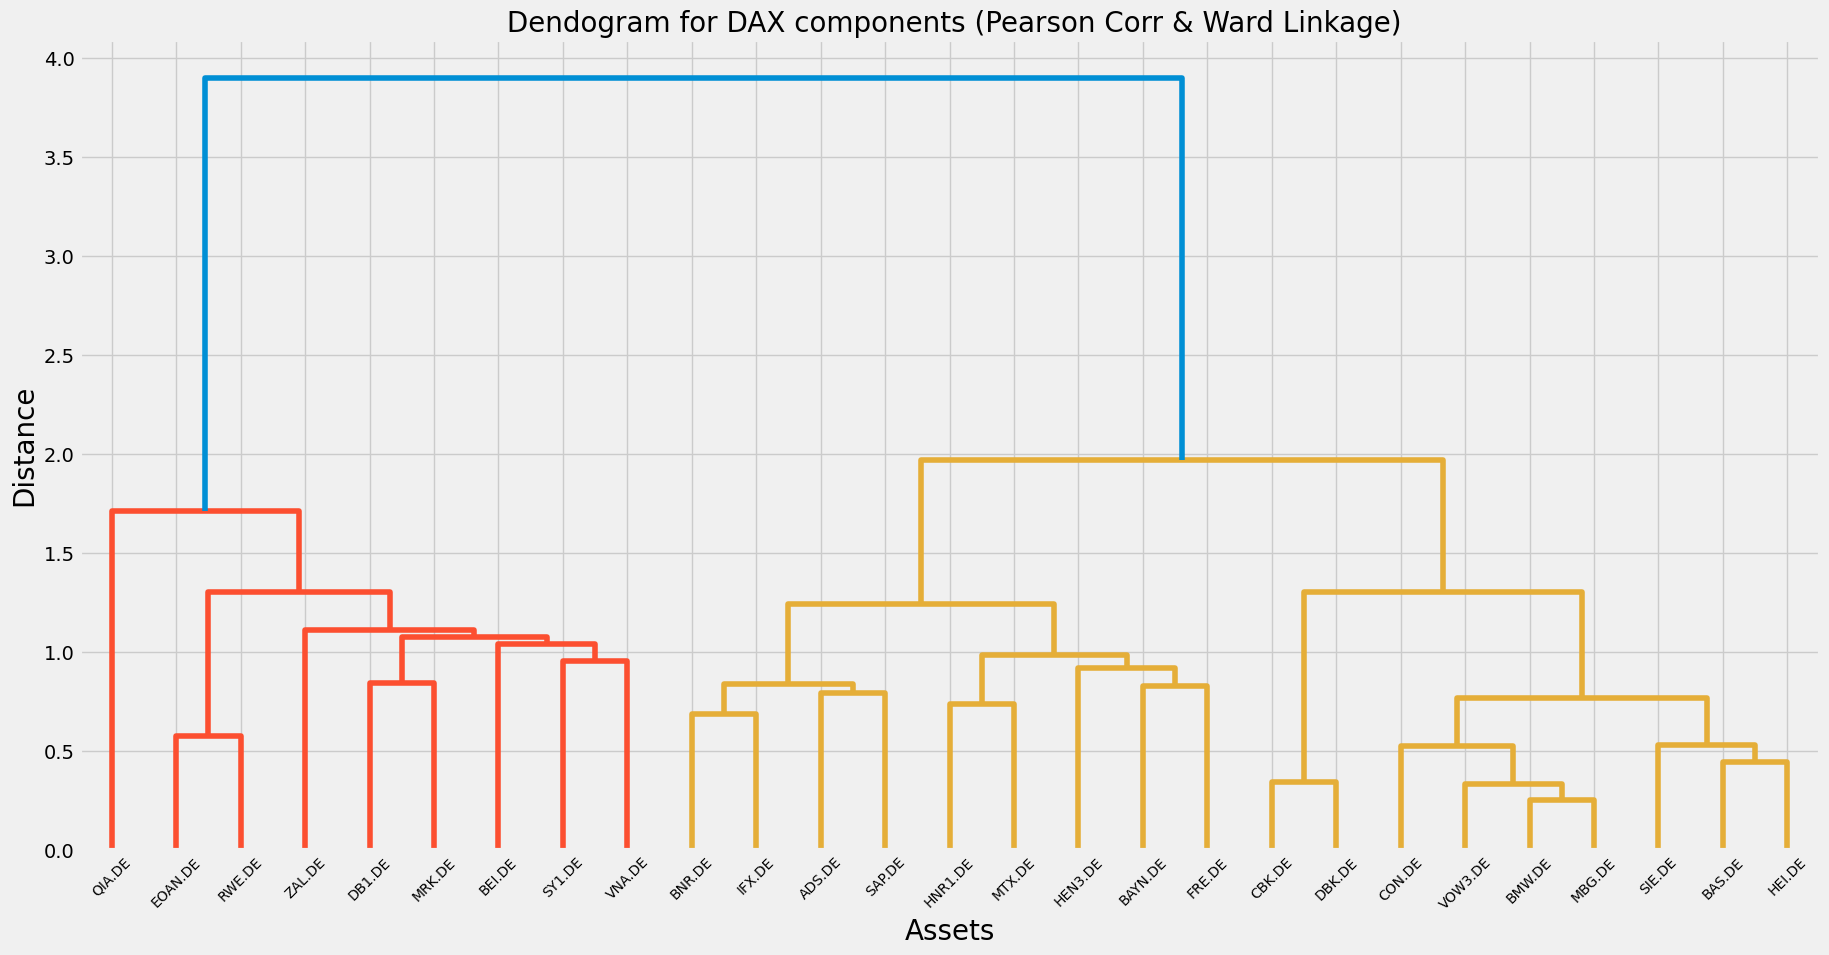

In [ ]:
# Hierarchical Clustering Dendogrames
plt.figure(figsize = (20, 10))
labelsize = 20
tciksize = 15
plt.title(' Dendogram for DAX components (Pearson Corr & Ward Linkage)', fontsize = labelsize)
plt.xlabel('Assets', fontsize = labelsize)
plt.ylabel('Distance', fontsize = labelsize)
dendrogram(linkage_de,
           leaf_rotation = 45,   # rotate x axis
           leaf_font_size = 10,  # text font size on x axis
           labels = corr_de.columns)
plt.show()

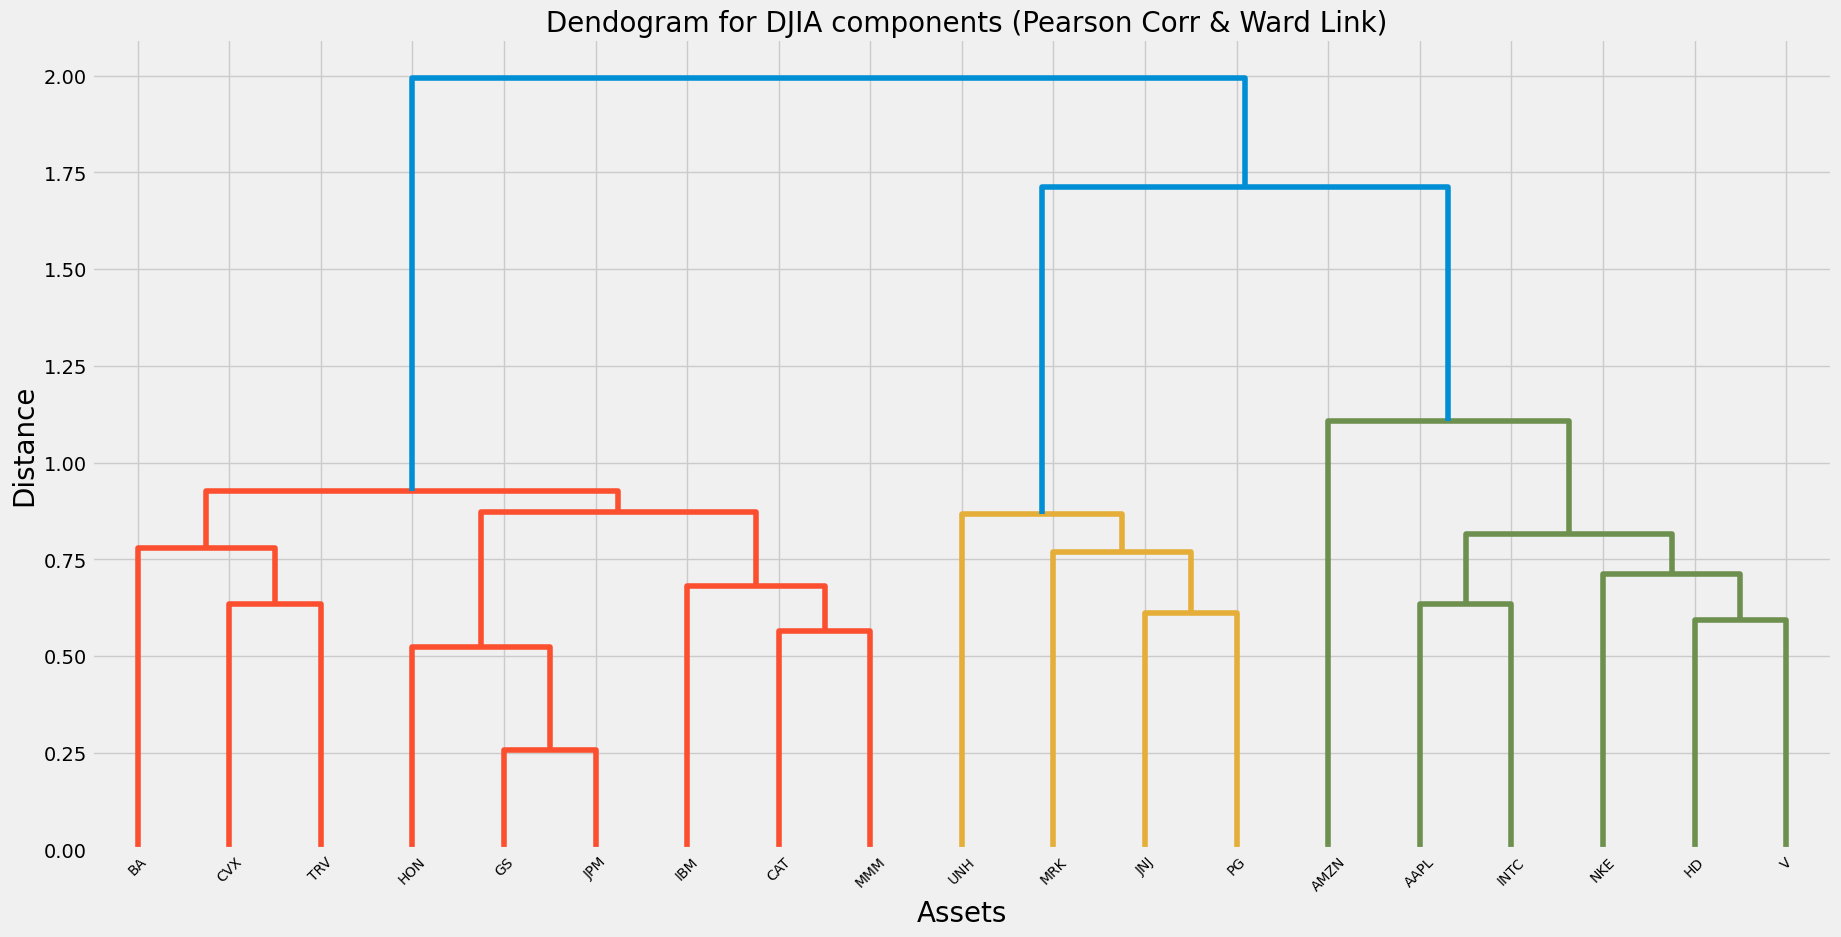

In [ ]:
# Hierarchical Clustering Dendogrames
plt.figure(figsize = (20, 10))
labelsize = 20
tciksize = 15
plt.title(' Dendogram for DJIA components (Pearson Corr & Ward Link)', fontsize = labelsize)
plt.xlabel('Assets', fontsize = labelsize)
plt.ylabel('Distance', fontsize = labelsize)
dendrogram(linkage_us,
           leaf_rotation = 45,   # rotate x axis
           leaf_font_size = 10,  # text font size on x axis
           labels = corr_us.columns)
plt.show()

BMW and MBG are most correlated stocks under DAX, while GS and JPM are under DJIA.

In [ ]:
# Obtain tickers
# This is the column names of the data frames used for in-sample estimation
o_tickers = {'DAX-40': list(Returns['DAX-40'].columns), 'DJIA-30':  list(Returns['DJIA-30'].columns)}

In [ ]:
# Download out-sample data
start = '2023-01-01'
end = '2024-06-28'
freq = '1d'
Data_test = ({key: read_data(ticker, start, end, freq) for key, ticker in
           o_tickers.items()})

[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  19 of 19 completed


In [ ]:
#!pip install PyPortfolioOpt

In [ ]:
from pypfopt.hierarchical_portfolio import HRPOpt

#wgs = HRPOpt(data_AI_ret)

# Assuming you have already instantiated the HRPOpt class and called the optimize method
hrp_opt = HRPOpt(returns= Returns['DAX-40'])
hrp_opt.optimize()

# Extracting weights
weights = hrp_opt.weights

print(weights * 100)

[2.47921535 2.01718506 3.95938453 7.97239309 1.70184705 3.54153812
 0.88726242 1.09123334 6.45335478 1.09253733 7.405781   3.34349832
 3.08313911 6.55517518 3.40952152 1.52039284 1.14079301 7.15319266
 1.87016602 7.1012424  5.6481696  3.43805222 2.01309398 7.12024199
 4.9233329  1.20273763 1.87551856]


In [ ]:
# Function to compute  hierarchical risk parity HRP optimum weights

def HRP_w(rets_df: pd.DataFrame, linkage_method: str = 'ward') -> pd.DataFrame:
  ''' Input: returns df, linkage method.
  output:  Hierarchical Risk Parity weights
  '''
  hrp_opt = HRPOpt(returns= rets_df, cov_matrix = None)
  # construct a HRP using Scipy Hierarchical Clustering: linkage_method = linkage method
  hrp_opt.optimize(linkage_method=  linkage_method)
  #hrp_opt.optimize(linkage_method=linkage_method
  hrp_w = pd.DataFrame(hrp_opt.weights, index = rets_df.columns)
  return hrp_w

In [ ]:
#HRP_w(Returns['DAX-40'])

w  =   {key: HRP_w(returns) for key, returns in Returns.items()}
#pd.concat(w)
#w['DAX-40'].sum()
W = pd.concat(w)
w['DAX-40'].T

Ticker,ADS.DE,BAS.DE,BAYN.DE,BEI.DE,BMW.DE,BNR.DE,CBK.DE,CON.DE,DB1.DE,DBK.DE,...,MRK.DE,MTX.DE,QIA.DE,RWE.DE,SAP.DE,SIE.DE,SY1.DE,VNA.DE,VOW3.DE,ZAL.DE
0,0.023657,0.021677,0.027632,0.084787,0.021345,0.02837,0.010851,0.023159,0.080366,0.013362,...,0.044908,0.016852,0.058657,0.034904,0.040968,0.056581,0.053824,0.038726,0.014165,0.021629


<Axes: xlabel='Ticker'>

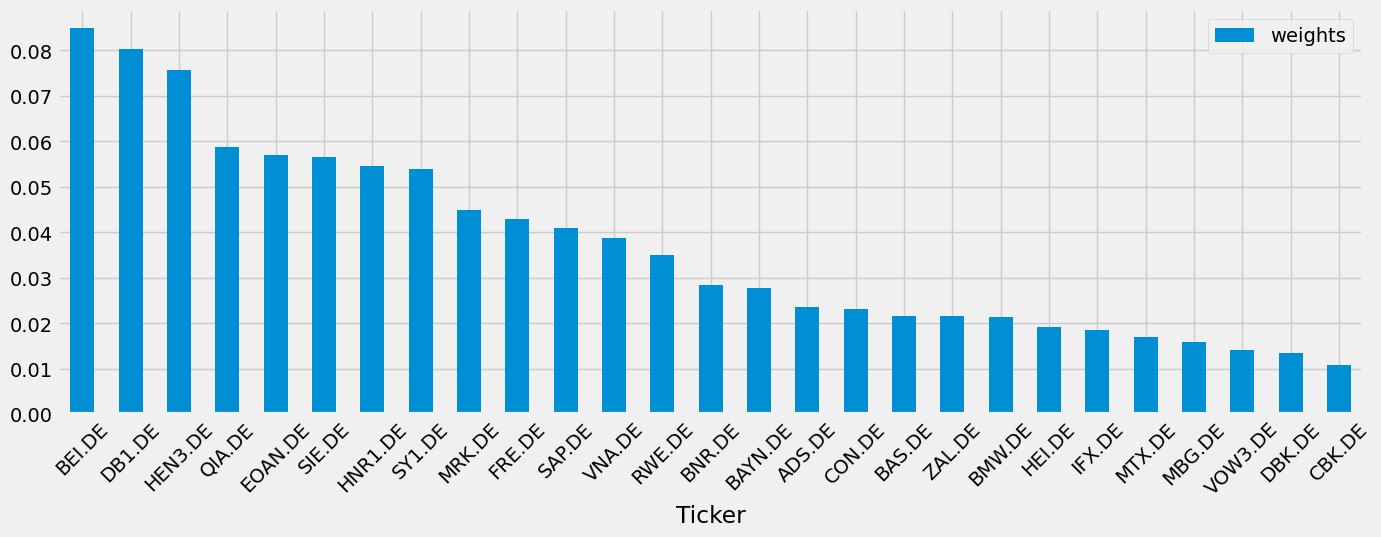

In [ ]:
df = w['DAX-40']   #pd.DataFrame({'weights': W * 100, 'tickers': Returns['DAX-40'].columns})
df.columns = ['weights']

# to sort

#df.nlargest(n, 'tickers')
#df.query('column_name == "value"') #extract a label
df.sort_values(by = 'weights', ascending= False ).plot.bar( rot=45 , figsize = (15, 5))

In [ ]:
from pypfopt.hierarchical_portfolio import HRPOpt

#wgs = HRPOpt(data_AI_ret)

# Assuming you have already instantiated the HRPOpt class and called the optimize method
hrp_opt = HRPOpt(returns= Returns['DJIA-30'])
hrp_opt.optimize()

# Extracting weights
weights = hrp_opt.weights

print(weights * 100)

[ 2.89302143  4.86562893  2.4090732   3.80151112  4.17284846  1.87829996
  3.92835146  5.12184068  6.74778142  3.87343303 11.7886702   1.99616571
  5.75644638  9.49767003  4.99490254 11.72103758  4.27818661  6.3080575
  3.96707376]


<Axes: xlabel='Ticker'>

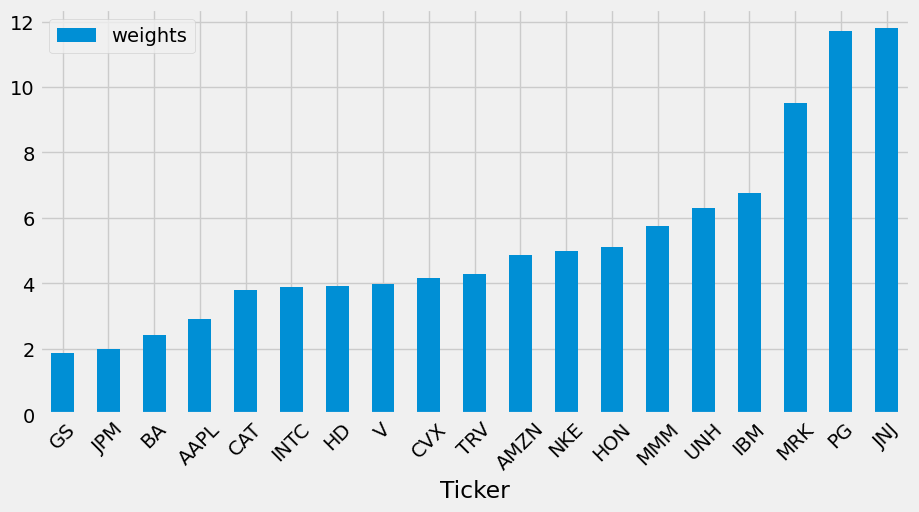

In [ ]:
W_df = pd.DataFrame({'weights': weights * 100, 'ticker': Returns['DJIA-30'].columns})
W_df = pd.DataFrame(data = weights * 100, index =  Returns['DJIA-30'].columns )
W_df.columns = ['weights']
W_df.sort_values(by = 'weights').plot.bar( rot=45 , figsize = (10, 5))

In [ ]:
np.transpose(W_df)

Ticker,AAPL,AMZN,BA,CAT,CVX,GS,HD,HON,IBM,INTC,JNJ,JPM,MMM,MRK,NKE,PG,TRV,UNH,V
weights,2.893021,4.865629,2.409073,3.801511,4.172848,1.8783,3.928351,5.121841,6.747781,3.873433,11.78867,1.996166,5.756446,9.49767,4.994903,11.721038,4.278187,6.308057,3.967074


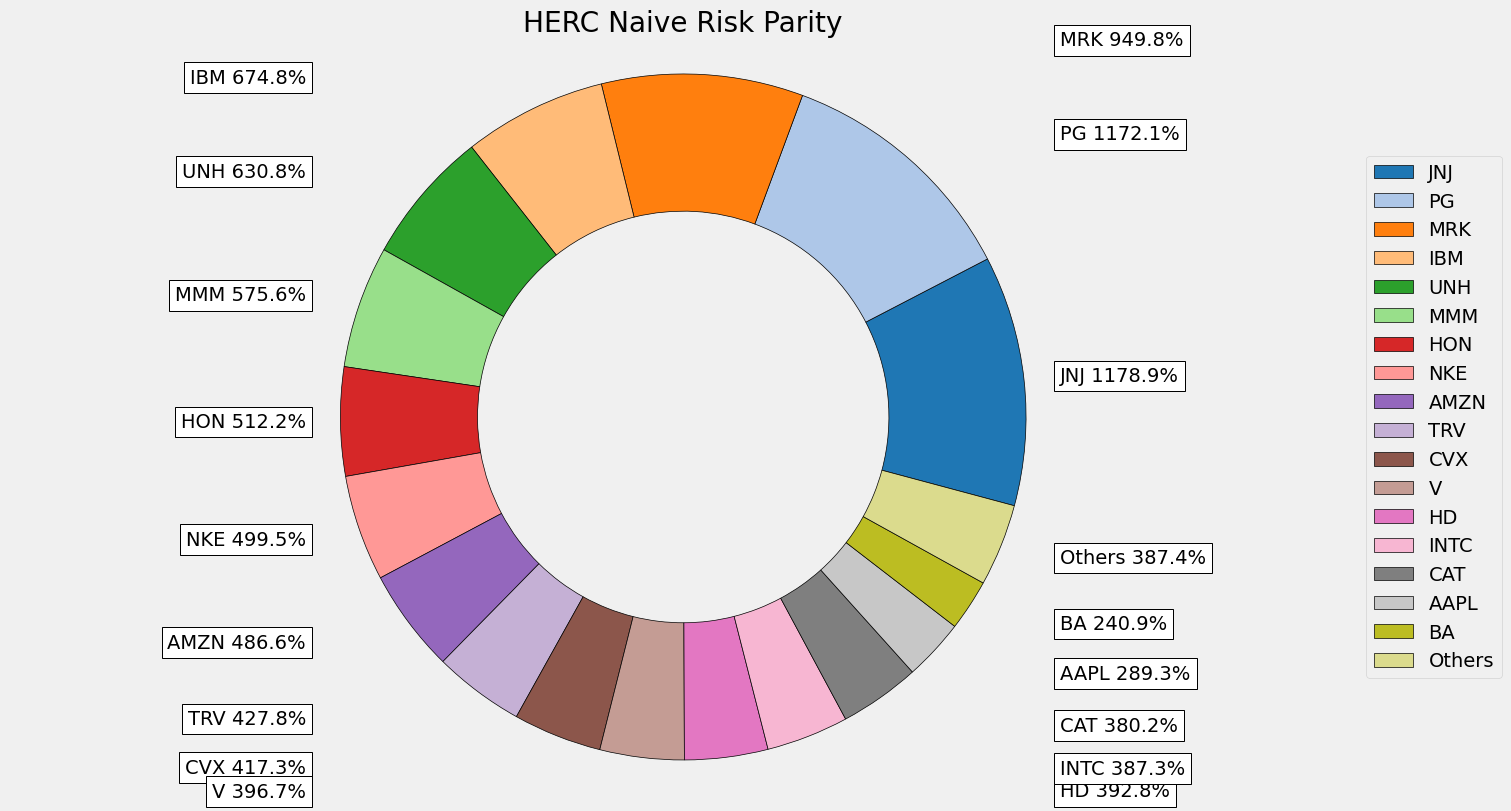

In [ ]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=  W_df,
                 title='HERC Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=15,
                 ax=None)

In [ ]:
#from transformers import BertTokenizer, BertForSequenceClassification
#from transformers import pipeline

# Load the FinBERT model and tokenizer from Hugging Face
#tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
#model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# Initialize pipeline for sentiment analysis
#nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Analyze the sentiment of a financial text
text = "The company's profits majorly increased this quarter, although expenses where higher!"
#text = "The company's profits did not  increase this quarter, also expenses where high!"
result = nlp(text)

print(result)  # Output: [{'label': 'positive', 'score': 0.95}]


[{'label': 'Positive', 'score': 0.9999994039535522}]


“In intuitive terms, we can understand the above empirical results as follows: Shocks affecting a specific investment penalize CLA’s concentration. Shocks involving several correlated investments penalize IVP’s ignorance of the correlation structure. HRP provides better protection against both common and idiosyncratic shocks by finding a compromise between diversification across all investments and diversification across clusters of investments at multiple hierarchical levels.”

Excerpt From
Advances in Financial Machine Learning
Lopez de Prado, Marcos;
This material may be protected by copyright.

# References

- López de Prado, M. (2016). Building Diversified Portfolios that Outperform Out of Sample. The Journal of Portfolio Management, 42(4), 59-69.

- López de Prado, M. (2018). $\textit{Advances in Financial Machine Learning}$. John Wiley & Sons.

